In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import glob 
import os
from scipy.stats import rankdata
from scipy.signal import savgol_filter
# 忽略特定类型的警告，例如 DeprecationWarning
warnings.filterwarnings("ignore")

#### 相关函数的定义

In [275]:
# 获取路径下的文件函数
def get_file_list(file_path):
    '''
    file_path:str        # 文件夹路径
    return:list          # 返回对应文件夹下所有对应格式组成的路径列表
    '''
    file_list = glob.glob(os.path.join(file_path,'*csv'))
    
    return file_list

#  =====================================Q值估计相关函数==============================
def get_lickNolick_reward_values(df,stage_index):
    '''
    分析不同阶段小鼠在go信号下对小鼠的动作进行奖励编码,
    并将小鼠的行为lick,nolick进行分类标志
    '''
    # R = 0  
    if df.loc[stage_index,'outcome'] ==1:      # Hit
            R = 1.0
            lickSig = 1                            # 小鼠行为标志位
    elif df.loc[stage_index,'outcome'] == 2:   # Miss
            R = 0.1
            lickSig = 0
    elif df.loc[stage_index,'outcome'] == 3:   # CR
            R = 0.1
            lickSig = 0
    elif df.loc[stage_index,'outcome'] == 4:   # FA
            R = -1.0
            lickSig = 1
    elif df.loc[stage_index,'outcome'] == 5:   # RO
            R = 0.1
            lickSig = 1
    
    return R,lickSig


def get_Q_list_SARSAandQL(df_go,stagename,alpha,gamma):
    '''
    df: dataframe 传入数据行为每一次试验,column0:每次试验所给的信号,column1:为每次输出的结果或者动作.
    N_STATES: 所切换的状态的总数,如试验的总次数.
    ALPHA: float 取值为0~1,学习率
    GAMMA: float 取值为0~1,折扣率
    stage_name: 获取Q值的阶段,如stable,uncertain,reverse
    return Q_go: 返回单步更新的 Q_lick,Q_nolick的值
    # 算法原理（贝尔曼方程）
    # Q(s, a) = Q(s, a) + α(r + γ * Q(s', a') - Q(s, a))
    '''
    Q_go = []                         # 创建存储迭代过程的go_Q值空列表

    if stagename == 'pre_training':
        # 初始化迭代初值
        Qs_go_lick = 0
        Qs_go_nolick = 0

        ALPHA = alpha
        GAMMA = gamma

    else:
        Qs_go_lick = 0.98
        Qs_go_nolick = 0.028

        ALPHA = alpha
        GAMMA = gamma

    Q_go.append([Qs_go_lick,Qs_go_nolick])
    go_N_STATES = np.array(df_go).shape[0]

    for i in range(go_N_STATES-1):
        
        R,lickSig = get_lickNolick_reward_values(df_go,i)
        # Qs_go_next_R,next_lickSig = get_lickNolick_reward_values(df_go,i+1)

        Qs_go_next_R = 1   # Q-learning

        if lickSig ==1:
            Qs_go_lick = Qs_go_lick + ALPHA*(R + GAMMA * Qs_go_next_R - Qs_go_lick)
        else:
            Qs_go_nolick = Qs_go_nolick + ALPHA*(R + GAMMA * Qs_go_next_R - Qs_go_nolick)

        Q_go.append([Qs_go_lick,Qs_go_nolick])

    return Q_go 


def get_Q_list_TD0(df_go,alpha_init,alpha_discount,pe_discount):
    '''
    df: dataframe 传入数据行为每一次试验,column0:每次试验所给的信号,column1:为每次输出的结果或者动作.
    N_STATES: 所切换的状态的总数,如试验的总次数.
    ALPHA: float 取值为0~1,学习率
    GAMMA: float 取值为0~1,折扣率
    stage_name: 获取Q值的阶段,如stable,uncertain,reverse
    return Q_go,Q_nogo: 返回单步更新的 Q_go,Q_nogo 值
    
    '''
    # 迭代超参数设置
    THETA = pe_discount
    THETA_p = alpha_discount
    PE = 0

    Q_go = []                         # 创建存储迭代过程的go_Q值空列表
    alpha_list = []                   # 创建存储迭代过程的alpha值空列表
    pre_err = []                      # 创建存储迭代过程的PE值空列表

    Qs_go_lick = 0.98
    Qs_go_nolick = 0.028
    ALPHA = alpha_init
    GAMMA = 0

    Q_go.append([Qs_go_lick,Qs_go_nolick])
    alpha_list.append(ALPHA)
    pre_err.append(PE)

    go_N_STATES = np.array(df_go).shape[0]

    for i in range(go_N_STATES-1):
    # for i in range(go_N_STATES):
        
        R,lickSig = get_lickNolick_reward_values(df_go,i)

        if lickSig ==1:
            PE= R - Qs_go_lick
            ALPHA = THETA_p*ALPHA+THETA*abs(PE)
            Qs_go_lick = Qs_go_lick + ALPHA*(R - Qs_go_lick)
            
        else:
            PE = R - Qs_go_nolick
            ALPHA = THETA_p*ALPHA+THETA*abs(PE)
            Qs_go_nolick = Qs_go_nolick + ALPHA*(R - Qs_go_nolick)

        alpha_list.append(ALPHA)
        pre_err.append(PE)
        Q_go.append([Qs_go_lick,Qs_go_nolick])

    return Q_go,alpha_list,pre_err


# ===================================QP转换相关函数==================================

def softmax_update_starev(Qstable, stable_Sfactor,Quncertain, uncertain_Sfactor,Qreverse, reverse_Sfactor):

    # e_Q0 = np.exp(pret_Sfactor * (Qpret - np.max(Qpret)))
    # P0 = e_Q0 / e_Q0.sum(axis=1, keepdims=True)

    e_Q1 = np.exp(stable_Sfactor * (Qstable - np.max(Qstable)))
    P1 = e_Q1 / e_Q1.sum(axis=1, keepdims=True)

    e_Q2 = np.exp(uncertain_Sfactor * (Quncertain - np.max(Quncertain)))
    P2 = e_Q2 / e_Q2.sum(axis=1, keepdims=True)

    e_Q3 = np.exp(reverse_Sfactor * (Qreverse - np.max(Qreverse)))
    P3 = e_Q3 / e_Q3.sum(axis=1, keepdims=True)
    
    P = np.concatenate((P1,P2,P3), axis=0)

    return P

# ===============================MCMC仿真序列生成相关函数============================

def get_genAction_ql(df,iter_num):

    stimu_df_list = []

    for iter_i in range(iter_num):
        # 随机选择动作序列和计算奖励
        # np.random.seed(400)  # 设置随机种子以确保结果可重复
        action_sequence = []
        stim_outcome = []  # 对选择进行编码
        motivation = [] # 对选择动机进行编码

        # 随机选择动作序列和计算奖励
        for _, row in df.iterrows():
            p_lick_ql = row['P_lick_ql']
            p_nolick_ql = row['P_nolick_ql']
            
            # 根据概率值选择CP或CG动作
            choice = np.random.choice(['lick', 'no_lick'], p=[p_lick_ql, p_nolick_ql])
            
            if choice == 'lick':
                st_outcome = 1  # lick
                motiv = 1
            elif choice == 'no_lick':
                st_outcome = 2  # no-lick
                motiv = 0
            
            action_sequence.append(choice)
            stim_outcome.append(st_outcome)
            motivation.append(motiv)
        
        # 创建一个新的DataFrame来存储这些变量的值
        stimu_df = pd.DataFrame({'action_sequence': action_sequence, 'stim_outcome': stim_outcome, 'motivation': motivation})
        stimu_df['iter_num'] = iter_i+1
        stimu_df_list.append(stimu_df)

    return stimu_df_list


def get_genAction(df,iter_num):

    stimu_df_list = []

    for iter_i in range(iter_num):
        # 随机选择动作序列和计算奖励
        # np.random.seed(400)  # 设置随机种子以确保结果可重复
        action_sequence = []
        stim_outcome = []  # 对选择进行编码
        motivation = [] # 对选择动机进行编码

        # 随机选择动作序列和计算奖励
        for _, row in df.iterrows():
            p_lick = row['P_lick']
            p_nolick = row['P_nolick']
            
            # 根据概率值选择CP或CG动作
            choice = np.random.choice(['lick', 'no_lick'], p=[p_lick, p_nolick])
            
            if choice == 'lick':
                st_outcome = 1  # lick
                motiv = 1
            elif choice == 'no_lick':
                st_outcome = 2  # no-lick
                motiv = 0
            
            action_sequence.append(choice)
            stim_outcome.append(st_outcome)
            motivation.append(motiv)
        
        # 创建一个新的DataFrame来存储这些变量的值
        stimu_df = pd.DataFrame({'action_sequence': action_sequence, 'stim_outcome': stim_outcome, 'motivation': motivation})
        stimu_df['iter_num'] = iter_i+1
        stimu_df_list.append(stimu_df)

    return stimu_df_list


# ==================================模型评估相关函数=================================
# 累计决策趋势一致性分析相关函数=======
def get_person_factor(sequence_1,sequence_2):
    sequence_x = sequence_1
    sequence_y = sequence_2
    # 计算均值
    mean_x = np.mean(sequence_x)
    mean_y = np.mean(sequence_y)
    # 计算皮尔逊相关系数
    numerator = np.sum((sequence_x - mean_x) * (sequence_y - mean_y))
    denominator_x = np.sqrt(np.sum((sequence_x - mean_x) ** 2))
    denominator_y = np.sqrt(np.sum((sequence_y - mean_y) ** 2))
    correlation_coefficient = numerator / (denominator_x * denominator_y)

    return correlation_coefficient


def spearman_rank_correlation(x, y):
    """
    计算两个序列的斯皮尔曼秩相关系数
    参数:
    x, y (array-like): 两个待比较的序列,可以是NumPy数组、列表或其他可迭代对象。
    返回: rho (float): 斯皮尔曼秩相关系数的值，范围在-1到1之间,越接近1表示越强的正相关性,越接近-1表示越强的负相关性。
    """
    # 使用rankdata函数将序列转换为秩
    ranks_x = rankdata(x)
    ranks_y = rankdata(y)
    # 计算秩的差值
    rank_diff = ranks_x - ranks_y
    # 计算斯皮尔曼秩相关系数
    n = len(x)
    rho = 1 - (6 * np.sum(rank_diff**2)) / (n * (n**2 - 1))

    return rho


# 滑动窗口相关函数 验证数理特性的一致性===============
def calculate_probability(sub_df,mode):
    '''
    mode:
    0:计算实验数据的概率    
    1:计算仿真数据的概率 
    '''
    if mode == 0:
        # 如果是实验数据,则滑动窗口截取go-nogo所有实验,统计go信号下的lick rate
        sub_df = sub_df[sub_df['stimulus']==1]
        total_rows = len(sub_df)
        outcome_1_rows = len(sub_df[sub_df['outcome'] == 1]) + len(sub_df[sub_df['outcome'] == 4]) + len(sub_df[sub_df['outcome'] == 5])
    else:
        outcome_1_rows = len(sub_df[sub_df['stim_outcome'] == 1])
        total_rows = len(sub_df)
    probability = outcome_1_rows / total_rows

    return probability

def slide_window_probabilities(df,windowSize,stepSize,Mode):

    window_size = windowSize  # 滑动窗口大小
    step_size = stepSize  # 步长

    probabilities = []  # 存储计算得到的概率值

    for i in range(0, len(df) - window_size + 1, step_size):
        sub_df = df.iloc[i:i+window_size]

        probability = calculate_probability(sub_df,Mode)

        probabilities.append(probability)

    return probabilities

#### 相关数据读入与写出设置

In [276]:
data_read_path = r'E:\project_wuqiyun\GUI_design\GUI_design_qiyun\RL_code\paper_data_contrast\pretraining-stable-reverse-restable\stable_uncertain_reverse\stable_uncertain_reverse1.csv'
# qp_save_path = r'E:\project_wuqiyun\GUI_design\GUI_design_qiyun\RL_code\paper_data_contrast\pretraining-stable-reverse-restable\QP_data\02QP.csv'
# stimu_save_path = r'E:\project_wuqiyun\GUI_design\GUI_design_qiyun\RL_code\paper_data_contrast\pretraining-stable-reverse-restable\simulation_data\02simulation.csv'
# stimu_save_path_ql = r'E:\project_wuqiyun\GUI_design\GUI_design_qiyun\RL_code\paper_data_contrast\pretraining-stable-reverse-restable\simulation_data\02simulation_ql.csv'
# param_save_path = r'E:\project_wuqiyun\GUI_design\GUI_design_qiyun\RL_code\paper_data_contrast\pretraining-stable-reverse-restable\param_data\02param.csv'

In [277]:
stimu_iterNum = 5000   # 设置仿真决策序列的采样次数
# 定义可调整的模型参数字典
model_params = {
    
    'alpha_init':0.1,
    'alpha_discount':0.6,
    'pe_discount': 0.6,

    'alpha_ql':0.1,
    'gramma_ql':0.9,
    
    'stable_SFactor':3.0,
    'uncertain_SFactor':1.3,
    'reverse_SFactor':2.2

}

# 将所设置的模型参数保存到本地
model_params_df = pd.DataFrame(model_params,index=[0])
# model_params_df.to_csv(param_save_path,index=False)

In [278]:
df1 = pd.read_csv(data_read_path,index_col=0)
df = df1[df1['stimulus']==1]
df.reset_index(inplace=True,drop=True)

# 创建映射字典,将有奖励和无奖励忽略，只关注选择类别
mapping_dict = {1: 1, 2: 2, 3: 2,4: 1,5: 1}
df['exp_outcome'] = df['outcome'].map(mapping_dict)

df.head(5)

,time_step,outcome_type,stimulus,outcome,stage,exp_outcome
0,44137,C1S7,1,1,stable,1
1,54836,C1S7,1,1,stable,1
2,64424,C1S7,1,1,stable,1
3,71326,C1S7,1,1,stable,1
4,78138,C1S7,1,1,stable,1


#### Q值计算

In [279]:
Q_list,alpha_list,pre_err_list = get_Q_list_TD0(df,model_params['alpha_init'],model_params['alpha_discount'],model_params['pe_discount'])
Q_list_ql = get_Q_list_SARSAandQL(df,'stable',model_params['alpha_ql'],model_params['gramma_ql'])

df_Q = pd.DataFrame(Q_list,columns=['Q_lick','Q_nolick'])
df_Q_ql = pd.DataFrame(Q_list_ql,columns=['Q_lick_ql','Q_nolick_ql']) #Q-learning 所获取的Q值

df = pd.concat([df,df_Q,df_Q_ql],axis=1)
df['alpha'] = alpha_list
df['Q_PE'] = pre_err_list

df.head(5)


,time_step,outcome_type,stimulus,outcome,stage,exp_outcome,Q_lick,Q_nolick,Q_lick_ql,Q_nolick_ql,alpha,Q_PE
0,44137,C1S7,1,1,stable,1,0.980000,0.028,0.980000,0.028,0.100000,0.000000
1,54836,C1S7,1,1,stable,1,0.981440,0.028,1.072000,0.028,0.072000,0.020000
2,64424,C1S7,1,1,stable,1,0.982448,0.028,1.154800,0.028,0.054336,0.018560
3,71326,C1S7,1,1,stable,1,0.983206,0.028,1.229320,0.028,0.043133,0.017552
4,78138,C1S7,1,1,stable,1,0.983809,0.028,1.296388,0.028,0.035956,0.016794


#### QP转化

In [280]:
# 将Q按照stage划分进行QP映射
# df_pretQ = df[df['stage'] == 'pre_training'][['Q_lick', 'Q_nolick']]
df_stableQ = df[df['stage'] == 'stable'][['Q_lick', 'Q_nolick']]
df_uncertainQ = df[df['stage'] == 'uncertain'][['Q_lick', 'Q_nolick']]
df_reverseQ = df[df['stage'] == 'reverse'][['Q_lick', 'Q_nolick']]
# Q-learning 
df_stableQ_ql = df[df['stage'] == 'stable'][['Q_lick_ql', 'Q_nolick_ql']]
df_uncertainQ_ql = df[df['stage'] == 'uncertain'][['Q_lick_ql', 'Q_nolick_ql']]
df_reverseQ_ql = df[df['stage'] == 'reverse'][['Q_lick_ql', 'Q_nolick_ql']]

# 通过QP映射函数,实现估值-概率转换
probabilities = softmax_update_starev(np.array(df_stableQ), model_params['stable_SFactor'],np.array(df_uncertainQ),model_params['uncertain_SFactor'],np.array(df_reverseQ),model_params['reverse_SFactor'])
probabilities_ql = softmax_update_starev(np.array(df_stableQ_ql), model_params['stable_SFactor'],np.array(df_uncertainQ_ql),model_params['uncertain_SFactor'],np.array(df_reverseQ_ql),model_params['reverse_SFactor'])

# print(probabilities)
df['P_lick'] = probabilities[:,0]
df['P_nolick'] = probabilities[:,1]
# Q-learning
df['P_lick_ql'] = probabilities_ql[:,0]
df['P_nolick_ql'] = probabilities_ql[:,1]
# 根据条件更新 motivation 列
df.loc[df['outcome'].isin([1, 4, 5]), 'motivation'] = 1
df.loc[df['outcome'].isin([3, 2]), 'motivation'] = 0

# 将基于真实决策序列的QP值保存到本地
# df.to_csv(qp_save_path)
df.head(5)

,time_step,outcome_type,stimulus,outcome,stage,exp_outcome,Q_lick,Q_nolick,Q_lick_ql,Q_nolick_ql,alpha,Q_PE,P_lick,P_nolick,P_lick_ql,P_nolick_ql,motivation
0,44137,C1S7,1,1,stable,1,0.980000,0.028,0.980000,0.028,0.100000,0.000000,0.945628,0.054372,0.945628,0.054372,1.0
1,54836,C1S7,1,1,stable,1,0.981440,0.028,1.072000,0.028,0.072000,0.020000,0.945850,0.054150,0.958194,0.041806,1.0
2,64424,C1S7,1,1,stable,1,0.982448,0.028,1.154800,0.028,0.054336,0.018560,0.946004,0.053996,0.967086,0.032914,1.0
3,71326,C1S7,1,1,stable,1,0.983206,0.028,1.229320,0.028,0.043133,0.017552,0.946120,0.053880,0.973505,0.026495,1.0
4,78138,C1S7,1,1,stable,1,0.983809,0.028,1.296388,0.028,0.035956,0.016794,0.946213,0.053787,0.978229,0.021771,1.0


#### MCMC仿真序列

In [281]:
# MCMC 重复采样，获取足够的决策序列
stimu_df_list = get_genAction(df,stimu_iterNum)
stimu_df_list_ql = get_genAction_ql(df,stimu_iterNum)

# stimu_df_list[0].head(5)

# 将生成的数据保存到本地
# auto-alpha
stimu_df_totol = pd.concat([df_stim for df_stim in stimu_df_list], axis=0)
# stimu_df_totol.to_csv(stimu_save_path)
# Q-learning
stimu_df_totol_ql = pd.concat([df_stim for df_stim in stimu_df_list_ql], axis=0)
# stimu_df_totol_ql.to_csv(stimu_save_path_ql)

#### 决策倾向一致性分析

In [282]:
cumul_motiv_df = np.cumsum(df['motivation'])
# print(cumul_motiv_df)
# 使用 concat 函数合并 'motivation' 列
def get_stimu_motiv_meanAndstd(stimu_df_list_1):
    motivation_concatenated = pd.concat([np.cumsum(df_stim['motivation']) for df_stim in stimu_df_list_1], axis=1)

    # 计算每行的均值和标准差
    mean_motivation_series = motivation_concatenated.mean(axis=1)
    std_values = motivation_concatenated.std(axis=1)

    motivation_lower = mean_motivation_series-1.96*std_values
    motivation_upper = mean_motivation_series+1.96*std_values

    return mean_motivation_series,motivation_lower,motivation_upper

mean_motivation_series,motivation_lower,motivation_upper = get_stimu_motiv_meanAndstd(stimu_df_list)
mean_motivation_series_ql,motivation_lower_ql,motivation_upper_ql = get_stimu_motiv_meanAndstd(stimu_df_list_ql)

# print(mean_motivation_series,std_values)

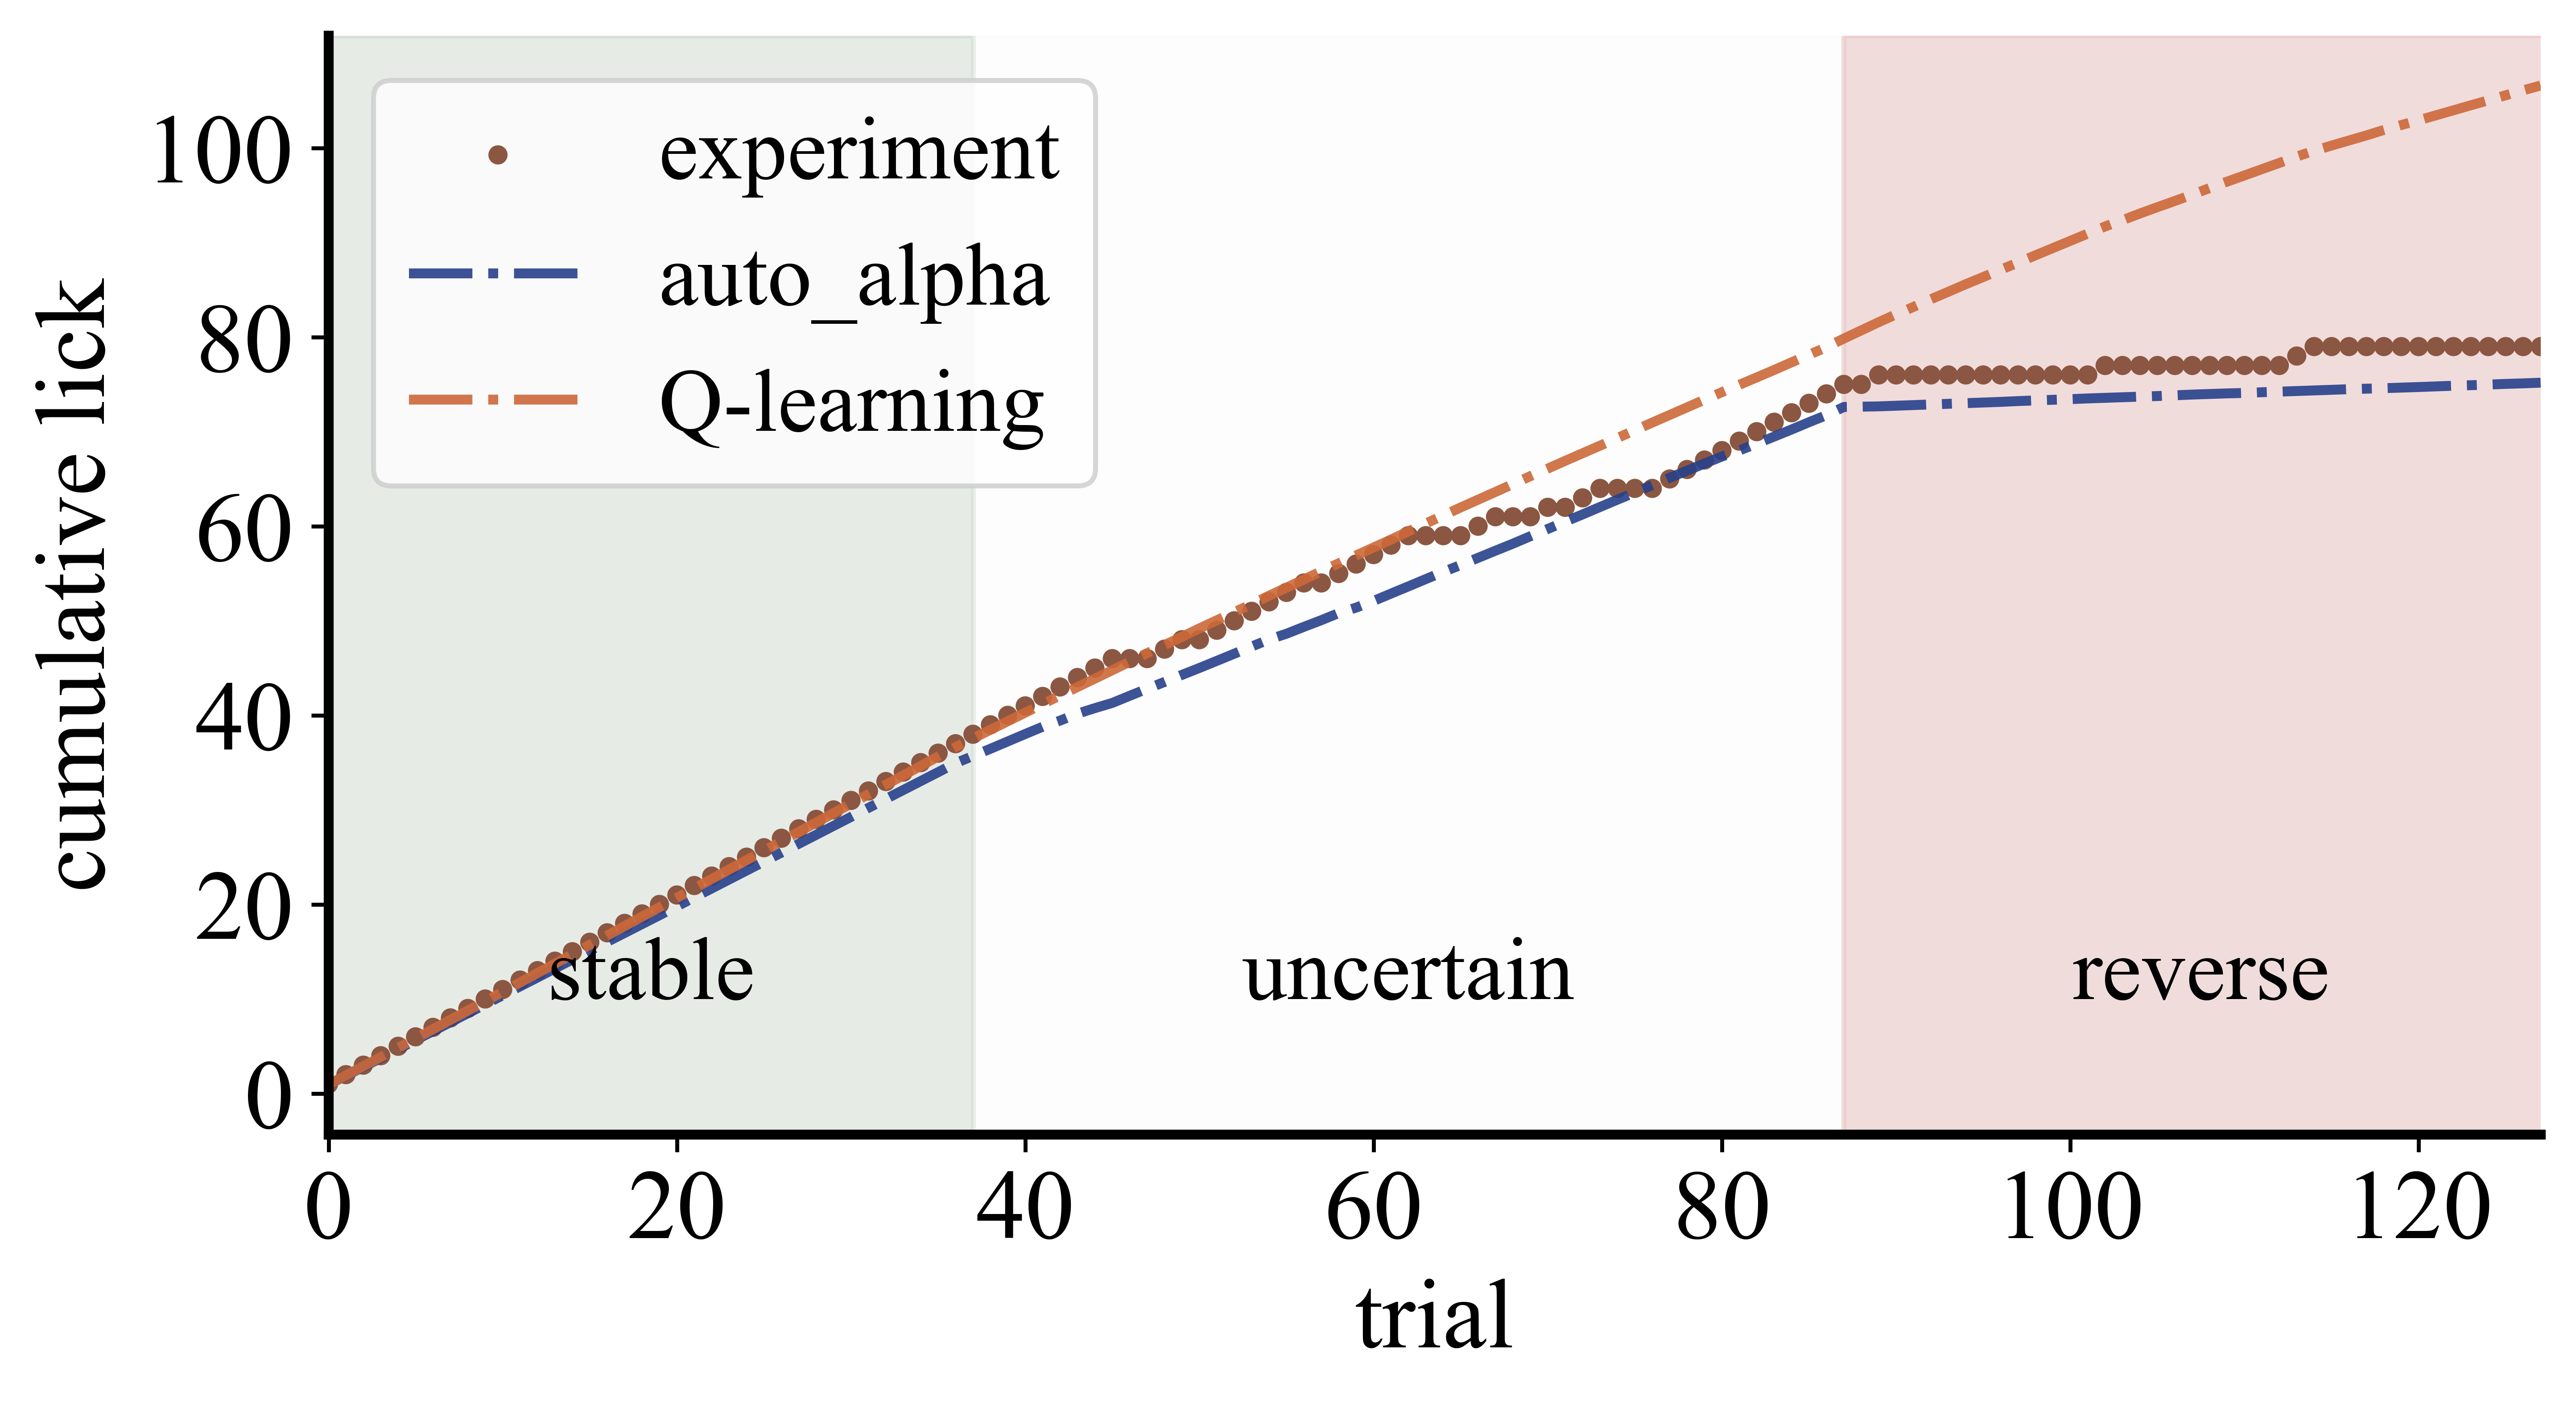

In [289]:
# 创建图形和轴
fig, ax = plt.subplots(figsize=(8, 4), dpi=800)

# 设置字体为新罗马字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 18

# 设置三个阶段的灰色背景
ax.axvspan(0, len(df_stableQ), color='#C1CDC1', alpha=0.4)
ax.axvspan(len(df_stableQ), len(df_stableQ) + len(df_uncertainQ), color='#F2F8F2', alpha=0.2)
ax.axvspan(len(df_stableQ) + len(df_uncertainQ), len(df_stableQ) + len(df_uncertainQ) + len(df_reverseQ), color='#E8C6C6', alpha=0.6)

ax.text(len(df_stableQ)/ 2, 10, 'stable', fontsize=18, ha='center')
ax.text(len(df_stableQ) + len(df_uncertainQ) / 2, 10, 'uncertain', fontsize=18, ha='center')
ax.text(len(df_stableQ) +len(df_uncertainQ) + len(df_reverseQ)/2, 10, 'reverse', fontsize=18, ha='center')

# 创建选择颜色映射
colors = {1: '#8E388E', 2: '#8E388E', 3: '#7ECBA4', 4: '#7ECBA4', 5: '#4ECBA4'}
# 绘制散点图
for i, action in enumerate(df['outcome']):
    # ax.scatter(i, cumul_motiv_df[i], marker='o', edgecolor='none', s=15, label='experiment' if i == 0 else "")
    ax.scatter(i, cumul_motiv_df[i], marker='o', edgecolor='none', facecolor='#8B5742', s=15, label='experiment' if i == 0 else "")
    # facecolor=colors[action]

# 绘制线图
ax.plot(range(len(mean_motivation_series)), mean_motivation_series, linestyle='-.', c='#27408B', label='auto_alpha', linewidth=2, alpha=0.9)
ax.plot(range(len(mean_motivation_series_ql)), mean_motivation_series_ql, linestyle='-.', c='#CD6839', label='Q-learning', linewidth=2, alpha=0.9)

# 设置边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
# 添加标签和标题
ax.set_xlim(0, len(mean_motivation_series) - 1)
ax.set_xlabel('trial')
ax.set_ylabel('cumulative lick')

ax.legend(loc='upper left')

# 显示图形
plt.show()


In [284]:
# # 绘制两个散点图
# plt.figure(figsize=(8,4),dpi=300)
# # 设置字体为新罗马字体
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Times New Roman'

# # 创建选择颜色映射
# colors = {1: '#8E388E', 2: '#8E388E',3: '#7ECBA4', 4: '#7ECBA4',5:'#4ECBA4'}

# # plt.fill_between(range(len(mean_motivation_series)), motivation_lower, motivation_upper, color='#607B8B',alpha=0.1)
# for i, action in enumerate(df['outcome']):
#     plt.scatter(i, cumul_motiv_df[i], marker='o', edgecolor='none', facecolor=colors[action],s=15)

# # plt.plot(range(len(cumul_motiv_df)), cumul_motiv_df, c='#8B5742', label='experiment',linewidth=0.2)
# plt.plot(range(len(mean_motivation_series)), mean_motivation_series,linestyle='-', c='#BCE0E6', label='auto_alpha',linewidth=2,alpha=0.9)
# plt.plot(range(len(mean_motivation_series_ql)), mean_motivation_series_ql,linestyle='-.', c='#A0A0E6', label='Q-learning',linewidth=2,alpha=0.9)

# # 添加标签和标题
# plt.xlim(0,len(mean_motivation_series)-1)
# plt.xlabel('trial')
# plt.ylabel('motivation\n(cumulative sum)')
# plt.title('motivation variation')

# plt.legend()
# # 显示皮尔逊相关系数
# # plt.annotate(f'Pearson Correlation = {persion:.2f}', (110, 14), fontsize=10, color='red')
# plt.show()

In [285]:
# 概率一致性分析
# 实验数据滑动窗口概率求解
window_size = 25
step_size = 1
real_P = slide_window_probabilities(df,window_size,step_size,0)
# print(real_P)

def get_stimuSlideWindow_p_list(stimu_df_list_2):
    # 仿真序列滑动窗口概率求解
    stimu_slide_P = []

    for df_sti in stimu_df_list_2:
        stim_P = slide_window_probabilities(df_sti,window_size,step_size,1)
        stimu_slide_P.append(stim_P)

    stimu_mean_P = np.mean(np.array(stimu_slide_P),axis=0)
    stimu_std_P = np.std(np.array(stimu_slide_P),axis=0)
    # 获取每一行最大值和最小值的概率值序列

    slide_Pmax = stimu_mean_P+1.96*stimu_std_P
    slide_Pmin = stimu_mean_P-1.96*stimu_std_P

    return slide_Pmax,slide_Pmin
# print(stimu_mean_P)
slide_Pmax,slide_Pmin = get_stimuSlideWindow_p_list(stimu_df_list)
slide_Pmax_ql,slide_Pmin_ql = get_stimuSlideWindow_p_list(stimu_df_list_ql)

In [286]:
# 使用Savitzky-Golay平滑方法，使得滑动窗口的样本概率变化趋于平滑
smoothed_real_P = savgol_filter(real_P, window_length=15, polyorder=3)
# 绘制原始数据和平滑曲线
# plt.plot(range(len(real_P)), real_P, label='raw_data')
# plt.plot(range(len(real_P)), smoothed_real_P, label='Savitzky-Golay')
# # 添加图例
# plt.legend()
# # 显示图形
# plt.show()

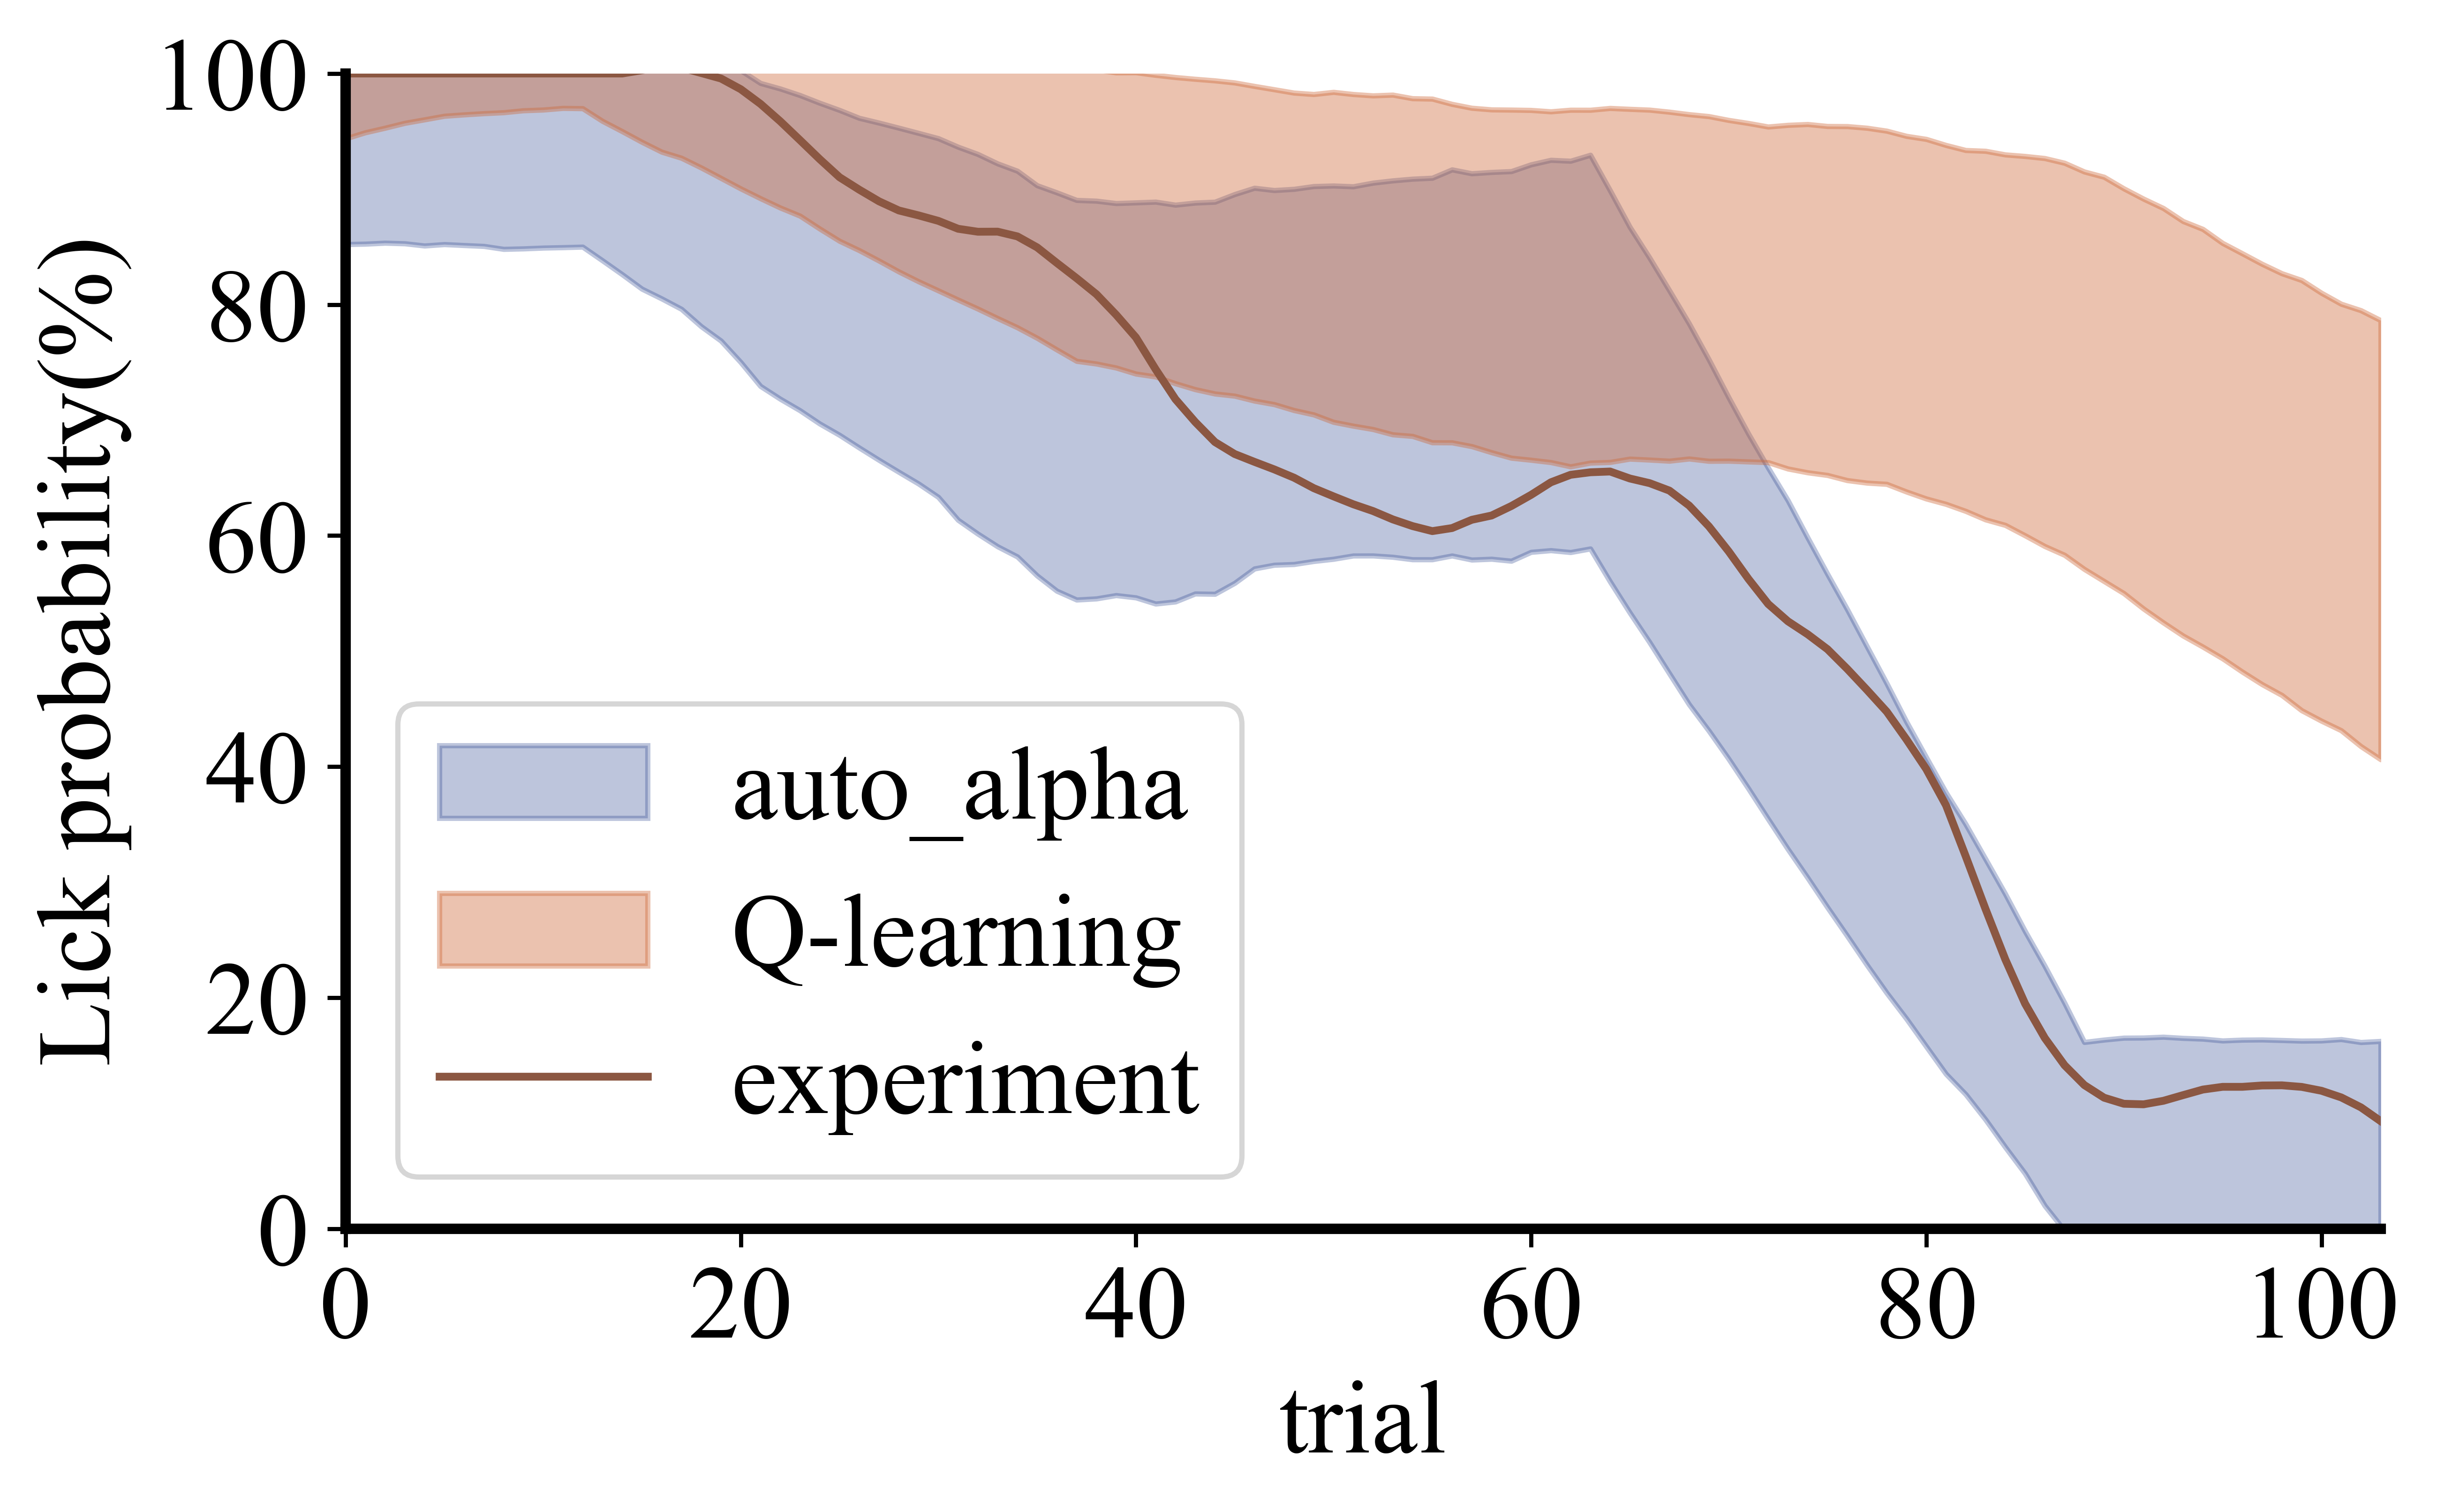

In [288]:
# 绘图展示滑动窗口的概率变化结果
fig, ax = plt.subplots(figsize=(7,4),dpi=800)
# 设置字体为新罗马字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

ax.set_xlim(0, len(slide_Pmin)-1)
ax.set_ylim(0, 100)

# 绘制三个阶段的背景色
# ax.axvspan(0, len(df_stableQ), color='#C1CDC1', alpha=0.4)
# ax.axvspan(len(df_stableQ), len(df_stableQ)  + len(df_uncertainQ)-15, color='#F0FFF0', alpha=0.4)
# ax.axvspan(len(df_stableQ)  + len(df_uncertainQ)-15, len(df_stableQ)  + len(df_uncertainQ) + len(df_reverseQ)-30, color='#F6F5E3', alpha=0.4)

# 添加阶段名称
# ax.text((len(df_stableQ)) / 2, 35, 'stable', fontsize=12, ha='center')
# ax.text(len(df_stableQ) + (len(df_uncertainQ)-15) / 2, 35, 'uncertain', fontsize=12, ha='center')
# ax.text(len(df_stableQ) +len(df_uncertainQ) + (len(df_reverseQ)-30) / 2, 35, 'reverse', fontsize=12, ha='center')

# 绘制概率变化结果
ax.fill_between(range(len(slide_Pmin)), slide_Pmin * 100, slide_Pmax * 100, color='#27408B', alpha=0.3, label='auto_alpha')
ax.fill_between(range(len(slide_Pmin_ql)), slide_Pmin_ql * 100, slide_Pmax_ql * 100, color='#CD6839', alpha=0.4, label='Q-learning')
ax.plot(range(len(real_P)), smoothed_real_P * 100, c='#8B5742', label='experiment')

# 设置边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# 添加标签和标题
ax.set_xlabel('trial')
ax.set_ylabel('Lick probability(%)')
# ax.set_title('probability variation')
ax.legend(loc='lower left')

# 使用tight_layout来确保布局紧凑
# plt.tight_layout()
# 展示图形
plt.show()
